In [2]:
#Rnn model to be trained on the data
#We have stock data for 20 years, With data formatted as follows:Date,Open,High,Low,Close,Volume,Dividends and Stock Splits
#For omx30 we can discard dividends and stock splits as they are not relevant for the prediction
#We want to output a predection for the next days high and low based on the previous days data
#We will use the open, high, low, close and volume as input to the model
import torch
import torch.nn as nn

class StockPricePredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(StockPricePredictor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 2)  # Output two values: next day's low and high prices

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

    

In [34]:
#Formatt the data to be used in the model
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data) - seq_length - 1):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

def create_data_loader(data, batch_size, seq_length):
    data = torch.tensor(data, dtype=torch.float32)
    dataset = torch.utils.data.TensorDataset(data)
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

def prepare_data(data, seq_length, train_proportion):
    data = data.drop(columns=["Dividends", "Stock Splits"])
    data = data.dropna()
    data = data.values

    train_size = int(len(data) * train_proportion)
    test_size = len(data) - train_size
    train_data, test_data = data[0:train_size], data[train_size:len(data)]

    x_train, y_train = create_sequences(train_data, seq_length)
    x_test, y_test = create_sequences(test_data, seq_length)

    train_loader = create_data_loader(x_train, 1, seq_length)
    test_loader = create_data_loader(x_test, 1, seq_length)

    return train_loader, test_loader, scaler


In [54]:
#Train the model
import torch.optim as optim
import matplotlib.pyplot as plt


device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

def train_model(model, train_loader, num_epochs):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = np.zeros(num_epochs)

    for epoch in range(num_epochs):
        model.train()
        loss = None

        for i, (inputs,) in enumerate(train_loader):
            outputs = model(inputs)
            optimizer.zero_grad()
            loss = criterion(outputs, inputs[:, -1, 2:4])
            loss.backward()
            optimizer.step()

        train_losses[epoch] = loss.item()
        print(f"Epoch {epoch} train loss: {loss.item()}")
        
    return train_losses

Using device: mps


In [55]:
#Test the model

#load data from csv 
data = pd.read_csv("omx30_data.csv")
#We can drop the date column as it is not relevant for the prediction
data = data.drop(columns=["Date"])
#Needs hyperparameter tuning to get better results it does not look like its overfitting so model could be more complex

train_loader, test_loader, scaler = prepare_data(data, seq_length=5, train_proportion=0.8)
model = StockPricePredictor(input_size=6, hidden_size=124, num_layers=4)

train_losses = train_model(model, train_loader, num_epochs=100)
plt.plot(train_losses)
plt.show()


Epoch 0 train loss: 3192263.0
Epoch 1 train loss: 2078539.125
Epoch 2 train loss: 1282982.5
Epoch 3 train loss: 798030.375
Epoch 4 train loss: 580402.125


KeyboardInterrupt: 

(3222, 2)



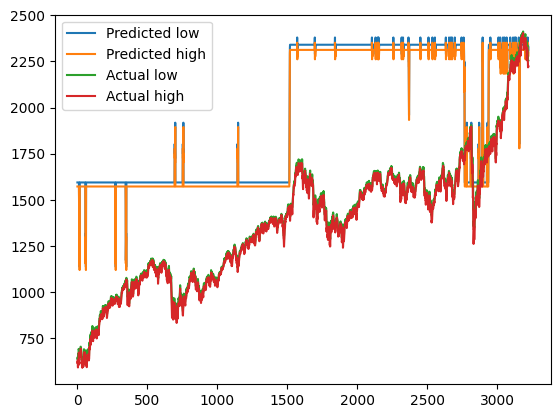

In [51]:
#Plot prediction vs actual for the test data
def test_model(model, test_loader, scaler):
    model.eval()
    predictions = np.zeros((len(test_loader), 2))
    actual = np.zeros((len(test_loader), 2))
    print(actual.shape) 
    print()

    with torch.no_grad():
        for i, (inputs,) in enumerate(test_loader):
            outputs = model(inputs)
            predictions[i] = outputs.numpy()
            actual[i] = inputs.numpy()[0, -1, 2:4]
            
    
    return predictions, actual

predictions, actual = test_model(model, train_loader, scaler)
Start_of_predictions = 0
End_of_predictions = 3222

plt.plot(predictions[Start_of_predictions:End_of_predictions, 0], label="Predicted low")
plt.plot(predictions[Start_of_predictions:End_of_predictions, 1], label="Predicted high")
plt.plot(actual[Start_of_predictions:End_of_predictions, 0], label="Actual low")
plt.plot(actual[Start_of_predictions:End_of_predictions, 1], label="Actual high")
plt.legend()
plt.show()
